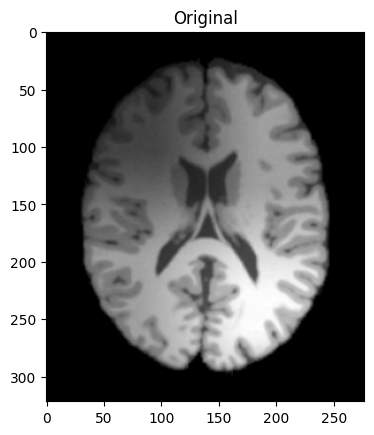

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = 'Sample_Image.jpg'
image = mpimg.imread(image_path)

# Convert the image into greyscale image
image_grey = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
plt.imshow(image_grey, cmap= 'gray')
plt.title('Original')
plt.show()


In [19]:
#Convert the data in 1d array 
image_grey_1d = image_grey.reshape(-1).copy()
# Fixed variables 
K=3
q=1.2
threshold_distance =2
error = 0.00001

# I initially set one cluster centre to 0 and then iteratively determined other cluster centre by finding the point wth maximium distance 
# from already chosen centroids and later removed the centroid with value 0.
def class_centre(image_grey_1d,K):
    centre = []
    centre.append(0)
    for _ in range(K):
        distance = []
        for i in image_grey_1d:
            if i==0:
                distance.append(0)
            else:
                h= [ ]
                for j in range(len(centre)):
                    h.append(abs(centre[j] - i))
                distance.append(min(h))
        centre.append(image_grey_1d[np.argmax(distance)])
    centre.remove(0)
    return np.array(centre)

# Initalizing a membership matrix using random numbers 
def initialize_membership_matrix(image_grey_1d, K):
    U = np.random.rand(image_grey_1d.shape[0], K)
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

def dis(i,j,width):
    ai,bi = divmod(i,width)
    cj,dj = divmod(j,width)
    return np.sqrt((ai-cj)**2 + (bi-dj)**2)

In [20]:
def weight(image_grey_1d,image_grey,threshold_distance):
    w = {}
    height, width = image_grey.shape
    limit = threshold_distance
    for i in range(image_grey_1d.shape[0]):
        if image_grey_1d[i]!=0:
            key = i
            value = np.array([0]*(min(i+1 + limit*width, len(image_grey_1d)) -max(i - limit*width, 0 )))
            w[key] = value
            a,b = divmod(i,width)
            h = image_grey[max(a-limit,0):min(a+limit+1,height), max(b-limit,0):min(b+limit+1,width)].reshape(-1).copy()
            h = (image_grey_1d[i] - h)**2
            vari = np.sum(h) / len(h)
            for j in range(max(i - limit*width, 0 ), min(i+1 + limit*width, len(image_grey_1d))):
                if dis(i,j,width) <= limit:
                    w[i][j-max(i-limit*width,0)] = np.exp(-(image_grey_1d[i]-image_grey_1d[j])**2 / (2*vari))
            w[i] = w[i] / np.sum(w[i])
    return w

In [21]:
def bias_field(w,U,centre,image_grey_1d, image_grey, K, threshold_distance):
    height,width = image_grey.shape
    limit = threshold_distance
    U_q = U**q
    a = np.dot(U_q, centre.reshape(3,1).copy())
    c = np.dot(U_q, (centre**2).reshape(3,1).copy())
    d = a.reshape(-1).copy() * image_grey_1d
    e = c.reshape(-1).copy()
    b= []
    for i in range(image_grey_1d.shape[0]):
        if image_grey_1d[i]==0:
            b.append(0)
        else: 
            num = np.dot(w[i], d[max(i-limit*width,0):min(i+1+limit*width,len(image_grey_1d))])
            den = np.dot(w[i], e[max(i-limit*width,0):min(i+1+limit*width,len(image_grey_1d))])
            b.append(num/den)
    return np.array(b)

In [22]:
def distance(w, image_grey_1d, b, centre, K,threshold_distance,image_grey):
    height,width = image_grey.shape
    limit = threshold_distance
    d = np.zeros((len(image_grey_1d), K))
    h = np.outer(b,centre)
    for j in range(len(image_grey_1d)):
        if(image_grey_1d[j]!=0):
            e  = (image_grey_1d[j]- h.copy()[max(j-limit*width,0):min(j+1+limit*width,len(image_grey_1d))])**2
            d[j]= np.dot(w[j].reshape(1,len(w[j])).copy(), e)
    return d

def update_membership(d, q):
    a = np.where(d==0,0 , 1 / np.where(d == 0,1 ,d))
    a_q = a**(1/(q-1))
    b = a_q.sum(axis =1)
    c = np.where(b ==0, 1, b)
    d = np.outer(c,np.array([1,1,1]))
    return (a_q/d)

def update_centre(U,w,b,image_grey_1d,threshold_distance,image_grey):
    height,width = image_grey.shape
    limit = threshold_distance
    U_q = U**q
    s = np.array([0.,0.,0.])
    l = np.array([0.,0.,0.])
    for j in range(len(image_grey_1d)):
        if image_grey_1d[j]!=0:
            s += (np.dot(w[j],b[max(j-limit*width,0):min(j+1+limit*width,len(image_grey_1d))]) * image_grey_1d[j])*U_q[j]
            l += (np.dot(w[j],(b**2)[max(j-limit*width,0):min(j+1+limit*width,len(image_grey_1d))]))*U_q[j]
    return s/l

In [23]:
def convol(b,w,image_grey,threshold_distance):
    height,width = image_grey.shape
    limit = threshold_distance
    for i in range(len(b)):
        if b[i] !=0:
            b[i] = np.dot(np.flip(w[i]),b[max(i-limit*width,0):min(i+1+limit*width,len(b))])
    return b

In [24]:
centre = class_centre(image_grey_1d,K)


In [25]:
U = initialize_membership_matrix(image_grey_1d,K)

In [26]:
w = weight(image_grey_1d,image_grey,threshold_distance)

In [27]:
b = bias_field(w,U,centre,image_grey_1d, image_grey, K, threshold_distance)

In [28]:
b = convol(b,w,image_grey,threshold_distance)

In [29]:
d = distance(w, image_grey_1d, b, centre, K,threshold_distance,image_grey)

In [30]:
U = update_membership(d, q)

In [31]:
centre  = update_centre(U,w,b,image_grey_1d,threshold_distance,image_grey)


In [32]:
b = bias_field(w,U,centre,image_grey_1d, image_grey, K, threshold_distance)

In [33]:
b = convol(b,w,image_grey,threshold_distance)

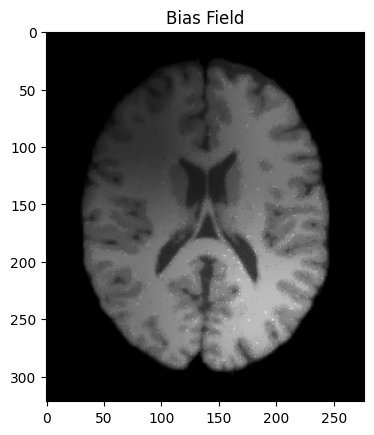

In [34]:
final_bias_field = b.reshape(image_grey.shape[0], image_grey.shape[1]).copy()
plt.imshow(final_bias_field, cmap = 'gray')
plt.title('Bias Field')
plt.show()